In [1]:
import tensorflow as tf
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load Data

In [2]:
def loadData():
    data = io.loadmat("face_landmark.mat")
    images = data["images"]
    landmarks = data["landmarks"]
    print("im_shape:", images.shape)
    print("landmarks_shape:", landmarks.shape)

    return images, landmarks

In [3]:
images, landmarks = loadData()

im_shape: (2140, 96, 96)
landmarks_shape: (2140, 15, 2)


# Visualize Data

In [4]:
def visualize_data(images, landmarks, num_images):
    fig = plt.figure(figsize=(10,10))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(num_images):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(images[i], cmap='gray')
        for (x, y) in landmarks[i].reshape(-1, 2):
            # Plot keypoints/landmarks on the image
            ax.scatter(x, y, marker='o', s=10, color='r')

    plt.show()

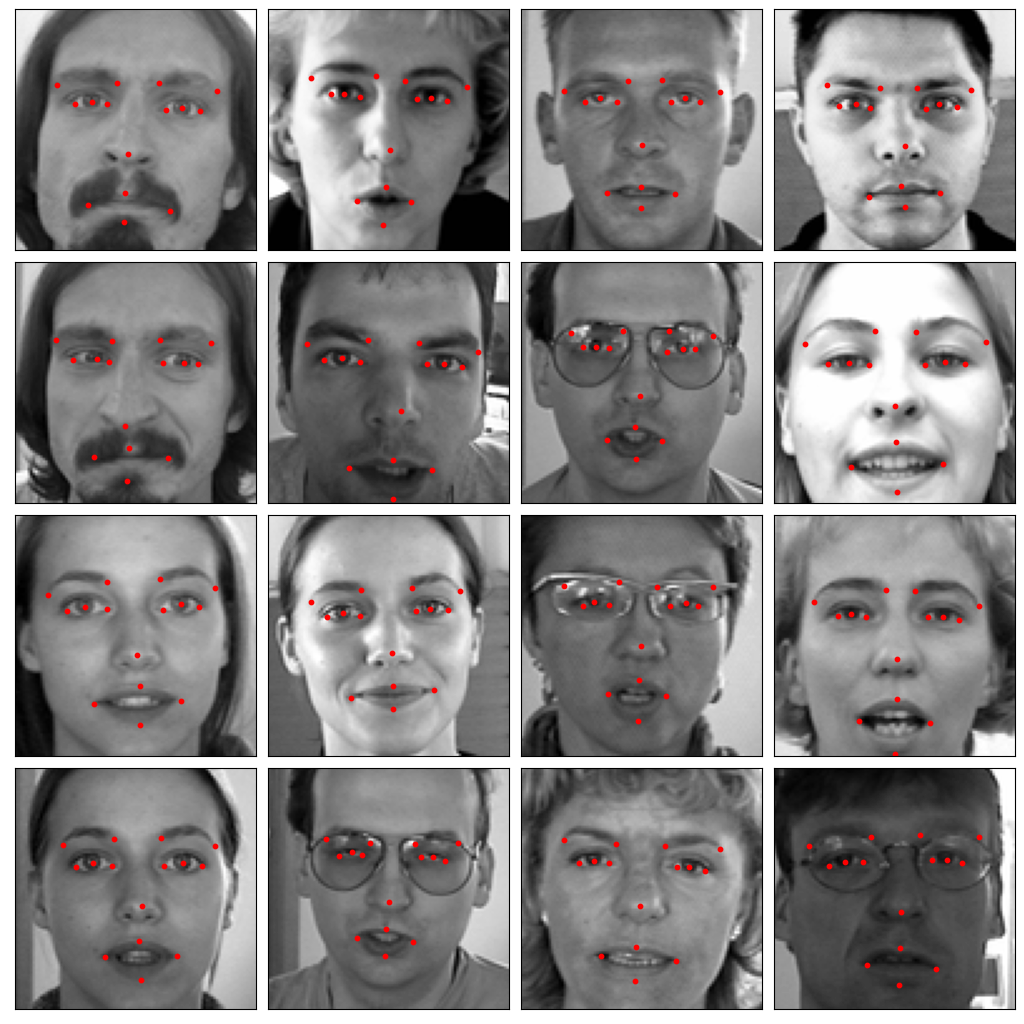

In [5]:
visualize_data(images, landmarks, num_images=16)

# Preprocessing

### split

In [6]:
def split_data(data, size):
    np.random.seed(2023)
    
    idx = np.random.permutation(size)

    train_size = int(size * 0.6)
    val_size = int(size * 0.2)
    test_size = int(size * 0.2)

    train_ds = data[idx[: train_size]]
    val_ds = data[idx[train_size: train_size + val_size]]
    test_ds = data[idx[size - test_size:]]

    return train_ds, val_ds, test_ds

In [7]:
train_img, val_img, test_img = split_data(images, images.shape[0])

In [8]:
train_lmrk, val_lmrk, test_lmrk = split_data(landmarks, landmarks.shape[0])

### Reshape

In [9]:
print(train_img.shape)
print(train_lmrk.shape)

(1284, 96, 96)
(1284, 15, 2)


In [10]:
print(val_img.shape)
print(val_lmrk.shape)

(428, 96, 96)
(428, 15, 2)


In [11]:
print(test_img.shape)
print(test_lmrk.shape)

(428, 96, 96)
(428, 15, 2)


In [12]:
train_lmrk = train_lmrk.reshape((1284, -1))
val_lmrk = val_lmrk.reshape((428, -1))
test_lmrk = test_lmrk.reshape((428, -1))

In [13]:
print(train_lmrk.shape)
print(val_lmrk.shape)
print(test_lmrk.shape)

(1284, 30)
(428, 30)
(428, 30)


# Model
* Output은 15개의 얼굴 랜드마크에 해당하는 x, y 좌표이므로 총 30개의 출력 유닛이 필요

In [14]:
# Define the input shape
input_layer = tf.keras.Input(shape=(96, 96, 1))

# Define the convolution and pooling layers
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.25)(x)

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.25)(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.25)(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.25)(x)

# Flatten the tensor output for the Fully Connected layer
x = tf.keras.layers.Flatten()(x)

# Define the fully connected layer
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

# Define the output layer (30 units for 15 landmarks x and y coordinates)
output_layer = tf.keras.layers.Dense(30)(x)

# Create the model
model = tf.keras.Model(input_layer, output_layer)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 47, 47, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                         

## Predict

In [15]:
@tf.function
def predict(x):
    return model(x, training=False)

# Optimization

In [16]:
@tf.function
def optimize(x,y_true,loss_function):
    with tf.GradientTape() as tape:
        y_pred = predict(x)
        loss = loss_function(y_pred, y_true)
    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [17]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Loss
* 실제 레이블(y_true)와 모델의 예측 결과(y)를 입력

In [18]:
@tf.function
def l1_loss(y_pred, y_true):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

@tf.function
def l2_loss(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_true - y_pred))

@tf.function
def cosine_loss(y_pred, y_true):
    # Normalize each vector
    y_true_normalized = tf.nn.l2_normalize(y_true, axis=-1)
    y_pred_normalized = tf.nn.l2_normalize(y_pred, axis=-1)
    # Compute the dot product (cosine similarity)
    dot_product = tf.reduce_sum(y_true_normalized * y_pred_normalized, axis=-1)
    # Subtract the dot product from 1 to get the loss
    return 1 - tf.reduce_mean(dot_product)


In [19]:
def combine_l2_cosine_loss(y_pred, y_true, lamda=0.6):
    return l2_loss(y_pred, y_true) + lamda*cosine_loss(y_pred, y_true)

# Train & Evaluation

In [20]:
""" start training """
loss_function = combine_l2_cosine_loss

max_epochs = 1000
batch_size = 32


loss_history = []
val_loss_best = np.inf
train_size = int(images.shape[0] * 0.6)

#Early stopping hyperparameter
patience = 50  # number of epochs to wait before stopping if there is no improvement
wait = 0  # counter for epochs without improvement


for epoch in range(max_epochs):
    # get a minibatch
    idx = np.random.permutation(train_size)
    batch_idx = idx[:batch_size]

    # optimize
    train_loss = optimize(train_img[batch_idx], train_lmrk[batch_idx], loss_function)
    train_loss = train_loss.numpy()

    # evaluate on val_set
    y = predict(val_img)
    val_loss = loss_function(y, val_lmrk).numpy()

    # Early stopping check
    if val_loss < val_loss_best:
        val_loss_best = val_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f'Early stopping on epoch {epoch}')
            break
        
    print('Epoch:', epoch, '. Training Loss:', train_loss, ' Validation Loss:', val_loss, ' Best Validation Loss:', val_loss_best)
    loss_history.append([train_loss, val_loss])

Epoch: 0 . Training Loss: 2642.0835  Validation Loss: 2335.554  Best Validation Loss: 2335.554
Epoch: 1 . Training Loss: 2332.2332  Validation Loss: 2011.9673  Best Validation Loss: 2011.9673
Epoch: 2 . Training Loss: 2008.6868  Validation Loss: 1670.0092  Best Validation Loss: 1670.0092
Epoch: 3 . Training Loss: 1648.2646  Validation Loss: 1540.6428  Best Validation Loss: 1540.6428
Epoch: 4 . Training Loss: 1534.7502  Validation Loss: 1417.2728  Best Validation Loss: 1417.2728
Epoch: 5 . Training Loss: 1454.3995  Validation Loss: 1210.2714  Best Validation Loss: 1210.2714
Epoch: 6 . Training Loss: 1230.8087  Validation Loss: 1109.88  Best Validation Loss: 1109.88
Epoch: 7 . Training Loss: 1082.2783  Validation Loss: 1047.7577  Best Validation Loss: 1047.7577
Epoch: 8 . Training Loss: 1057.7566  Validation Loss: 959.1007  Best Validation Loss: 959.1007
Epoch: 9 . Training Loss: 933.2691  Validation Loss: 856.93774  Best Validation Loss: 856.93774
Epoch: 10 . Training Loss: 816.63184  V

Epoch: 85 . Training Loss: 108.97273  Validation Loss: 113.75616  Best Validation Loss: 112.25208
Epoch: 86 . Training Loss: 86.41349  Validation Loss: 113.51951  Best Validation Loss: 112.25208
Epoch: 87 . Training Loss: 110.76158  Validation Loss: 120.03969  Best Validation Loss: 112.25208
Epoch: 88 . Training Loss: 170.3362  Validation Loss: 112.7361  Best Validation Loss: 112.25208
Epoch: 89 . Training Loss: 98.57112  Validation Loss: 122.52969  Best Validation Loss: 112.25208
Epoch: 90 . Training Loss: 76.19594  Validation Loss: 118.28824  Best Validation Loss: 112.25208
Epoch: 91 . Training Loss: 152.42914  Validation Loss: 112.888504  Best Validation Loss: 112.25208
Epoch: 92 . Training Loss: 122.44768  Validation Loss: 131.19862  Best Validation Loss: 112.25208
Epoch: 93 . Training Loss: 153.98523  Validation Loss: 116.65508  Best Validation Loss: 112.25208
Epoch: 94 . Training Loss: 85.04996  Validation Loss: 108.90924  Best Validation Loss: 108.90924
Epoch: 95 . Training Loss

Epoch: 175 . Training Loss: 59.707245  Validation Loss: 90.76485  Best Validation Loss: 90.76485
Epoch: 176 . Training Loss: 92.00476  Validation Loss: 90.50302  Best Validation Loss: 90.50302
Epoch: 177 . Training Loss: 101.60981  Validation Loss: 92.75445  Best Validation Loss: 90.50302
Epoch: 178 . Training Loss: 85.950905  Validation Loss: 91.24543  Best Validation Loss: 90.50302
Epoch: 179 . Training Loss: 64.98224  Validation Loss: 93.71273  Best Validation Loss: 90.50302
Epoch: 180 . Training Loss: 66.63311  Validation Loss: 93.427055  Best Validation Loss: 90.50302
Epoch: 181 . Training Loss: 82.98744  Validation Loss: 92.17627  Best Validation Loss: 90.50302
Epoch: 182 . Training Loss: 82.74603  Validation Loss: 107.460785  Best Validation Loss: 90.50302
Epoch: 183 . Training Loss: 96.91791  Validation Loss: 111.51864  Best Validation Loss: 90.50302
Epoch: 184 . Training Loss: 85.39458  Validation Loss: 91.53259  Best Validation Loss: 90.50302
Epoch: 185 . Training Loss: 74.28

Epoch: 264 . Training Loss: 84.96543  Validation Loss: 82.28751  Best Validation Loss: 73.63348
Epoch: 265 . Training Loss: 51.563984  Validation Loss: 92.01275  Best Validation Loss: 73.63348
Epoch: 266 . Training Loss: 90.3847  Validation Loss: 80.15125  Best Validation Loss: 73.63348
Epoch: 267 . Training Loss: 66.08067  Validation Loss: 74.35954  Best Validation Loss: 73.63348
Epoch: 268 . Training Loss: 55.609303  Validation Loss: 79.333084  Best Validation Loss: 73.63348
Epoch: 269 . Training Loss: 79.22067  Validation Loss: 81.39222  Best Validation Loss: 73.63348
Epoch: 270 . Training Loss: 54.847107  Validation Loss: 78.8248  Best Validation Loss: 73.63348
Epoch: 271 . Training Loss: 47.14639  Validation Loss: 73.925186  Best Validation Loss: 73.63348
Epoch: 272 . Training Loss: 54.180996  Validation Loss: 82.284035  Best Validation Loss: 73.63348
Epoch: 273 . Training Loss: 63.432144  Validation Loss: 84.05561  Best Validation Loss: 73.63348
Epoch: 274 . Training Loss: 79.605

Epoch: 355 . Training Loss: 52.799698  Validation Loss: 60.815826  Best Validation Loss: 60.378586
Epoch: 356 . Training Loss: 40.764477  Validation Loss: 61.02543  Best Validation Loss: 60.378586
Epoch: 357 . Training Loss: 40.972187  Validation Loss: 61.072525  Best Validation Loss: 60.378586
Epoch: 358 . Training Loss: 49.952477  Validation Loss: 60.53043  Best Validation Loss: 60.378586
Epoch: 359 . Training Loss: 49.02811  Validation Loss: 59.335026  Best Validation Loss: 59.335026
Epoch: 360 . Training Loss: 34.680244  Validation Loss: 59.31526  Best Validation Loss: 59.31526
Epoch: 361 . Training Loss: 44.992077  Validation Loss: 59.498672  Best Validation Loss: 59.31526
Epoch: 362 . Training Loss: 52.908752  Validation Loss: 61.473927  Best Validation Loss: 59.31526
Epoch: 363 . Training Loss: 35.614662  Validation Loss: 60.16848  Best Validation Loss: 59.31526
Epoch: 364 . Training Loss: 30.538109  Validation Loss: 61.163784  Best Validation Loss: 59.31526
Epoch: 365 . Trainin

Epoch: 439 . Training Loss: 45.5673  Validation Loss: 56.394287  Best Validation Loss: 51.917572
Epoch: 440 . Training Loss: 35.575787  Validation Loss: 51.37671  Best Validation Loss: 51.37671
Epoch: 441 . Training Loss: 27.74488  Validation Loss: 51.73713  Best Validation Loss: 51.37671
Epoch: 442 . Training Loss: 26.333698  Validation Loss: 50.84962  Best Validation Loss: 50.84962
Epoch: 443 . Training Loss: 38.36262  Validation Loss: 52.346107  Best Validation Loss: 50.84962
Epoch: 444 . Training Loss: 26.095661  Validation Loss: 53.7726  Best Validation Loss: 50.84962
Epoch: 445 . Training Loss: 38.301483  Validation Loss: 51.571102  Best Validation Loss: 50.84962
Epoch: 446 . Training Loss: 26.63326  Validation Loss: 54.246983  Best Validation Loss: 50.84962
Epoch: 447 . Training Loss: 34.07062  Validation Loss: 50.4077  Best Validation Loss: 50.4077
Epoch: 448 . Training Loss: 25.602806  Validation Loss: 55.823853  Best Validation Loss: 50.4077
Epoch: 449 . Training Loss: 33.597

Epoch: 524 . Training Loss: 36.84694  Validation Loss: 48.208458  Best Validation Loss: 46.63266
Epoch: 525 . Training Loss: 34.812664  Validation Loss: 46.15147  Best Validation Loss: 46.15147
Epoch: 526 . Training Loss: 24.048645  Validation Loss: 46.344288  Best Validation Loss: 46.15147
Epoch: 527 . Training Loss: 24.143806  Validation Loss: 46.187485  Best Validation Loss: 46.15147
Epoch: 528 . Training Loss: 24.144627  Validation Loss: 45.51669  Best Validation Loss: 45.51669
Epoch: 529 . Training Loss: 26.303019  Validation Loss: 45.598034  Best Validation Loss: 45.51669
Epoch: 530 . Training Loss: 20.52338  Validation Loss: 45.425953  Best Validation Loss: 45.425953
Epoch: 531 . Training Loss: 22.946568  Validation Loss: 47.9301  Best Validation Loss: 45.425953
Epoch: 532 . Training Loss: 33.26156  Validation Loss: 46.834084  Best Validation Loss: 45.425953
Epoch: 533 . Training Loss: 24.157688  Validation Loss: 59.057793  Best Validation Loss: 45.425953
Epoch: 534 . Training L

Epoch: 614 . Training Loss: 30.957762  Validation Loss: 45.434326  Best Validation Loss: 44.793465
Epoch: 615 . Training Loss: 19.465094  Validation Loss: 50.70195  Best Validation Loss: 44.793465
Epoch: 616 . Training Loss: 28.257078  Validation Loss: 49.548832  Best Validation Loss: 44.793465
Epoch: 617 . Training Loss: 17.873297  Validation Loss: 46.01948  Best Validation Loss: 44.793465
Epoch: 618 . Training Loss: 17.563606  Validation Loss: 50.934296  Best Validation Loss: 44.793465
Epoch: 619 . Training Loss: 34.999462  Validation Loss: 48.04314  Best Validation Loss: 44.793465
Epoch: 620 . Training Loss: 27.845617  Validation Loss: 45.890125  Best Validation Loss: 44.793465
Epoch: 621 . Training Loss: 20.46084  Validation Loss: 49.385616  Best Validation Loss: 44.793465
Epoch: 622 . Training Loss: 24.437717  Validation Loss: 45.963135  Best Validation Loss: 44.793465
Epoch: 623 . Training Loss: 22.259405  Validation Loss: 44.144005  Best Validation Loss: 44.144005
Epoch: 624 . T

Epoch: 704 . Training Loss: 23.401648  Validation Loss: 42.21111  Best Validation Loss: 42.062702
Epoch: 705 . Training Loss: 13.658199  Validation Loss: 53.13461  Best Validation Loss: 42.062702
Epoch: 706 . Training Loss: 23.66684  Validation Loss: 51.170654  Best Validation Loss: 42.062702
Epoch: 707 . Training Loss: 21.669542  Validation Loss: 43.63996  Best Validation Loss: 42.062702
Epoch: 708 . Training Loss: 16.7815  Validation Loss: 53.61991  Best Validation Loss: 42.062702
Epoch: 709 . Training Loss: 30.03954  Validation Loss: 51.944992  Best Validation Loss: 42.062702
Epoch: 710 . Training Loss: 32.82104  Validation Loss: 45.42615  Best Validation Loss: 42.062702
Epoch: 711 . Training Loss: 20.9877  Validation Loss: 50.689617  Best Validation Loss: 42.062702
Epoch: 712 . Training Loss: 18.040781  Validation Loss: 54.063026  Best Validation Loss: 42.062702
Epoch: 713 . Training Loss: 34.65663  Validation Loss: 44.23377  Best Validation Loss: 42.062702
Epoch: 714 . Training Lo

### visualization loss

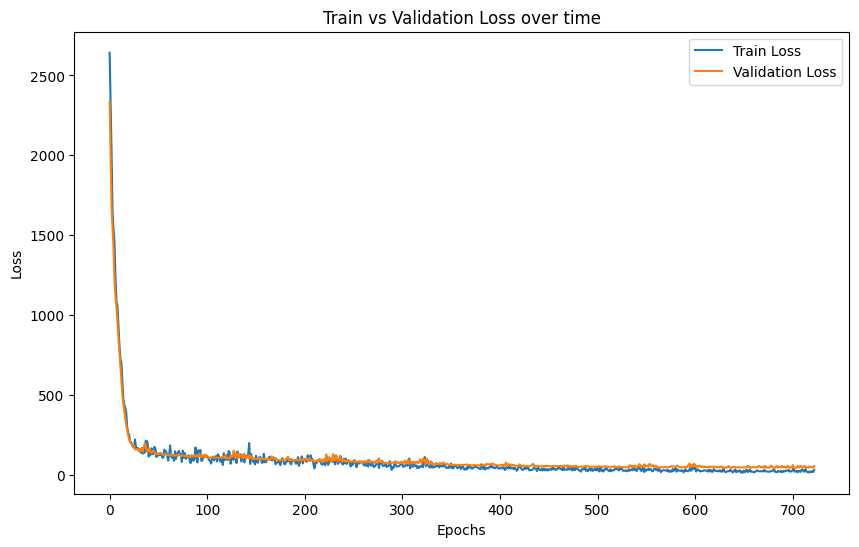

In [21]:
# Convert the history to a pandas dataframe
df_loss_history = pd.DataFrame(loss_history, columns=['train_loss', 'val_loss'])

# plot train and validation loss
plt.figure(figsize=(10, 6))
plt.plot(df_loss_history['train_loss'], label='Train Loss')
plt.plot(df_loss_history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss over time')
plt.legend()
plt.show()


### Evaluation

In [22]:
test_true = test_lmrk
test_pred = model.predict(test_img)

print("Combine L2 And Cosine Error: ", combine_l2_cosine_loss(test_true, test_pred).numpy())

14/14 [==============================] - 0s 6ms/step
Combine L2 And Cosine Error:  61.327724


### visualize result

14/14 [==============================] - 0s 2ms/step


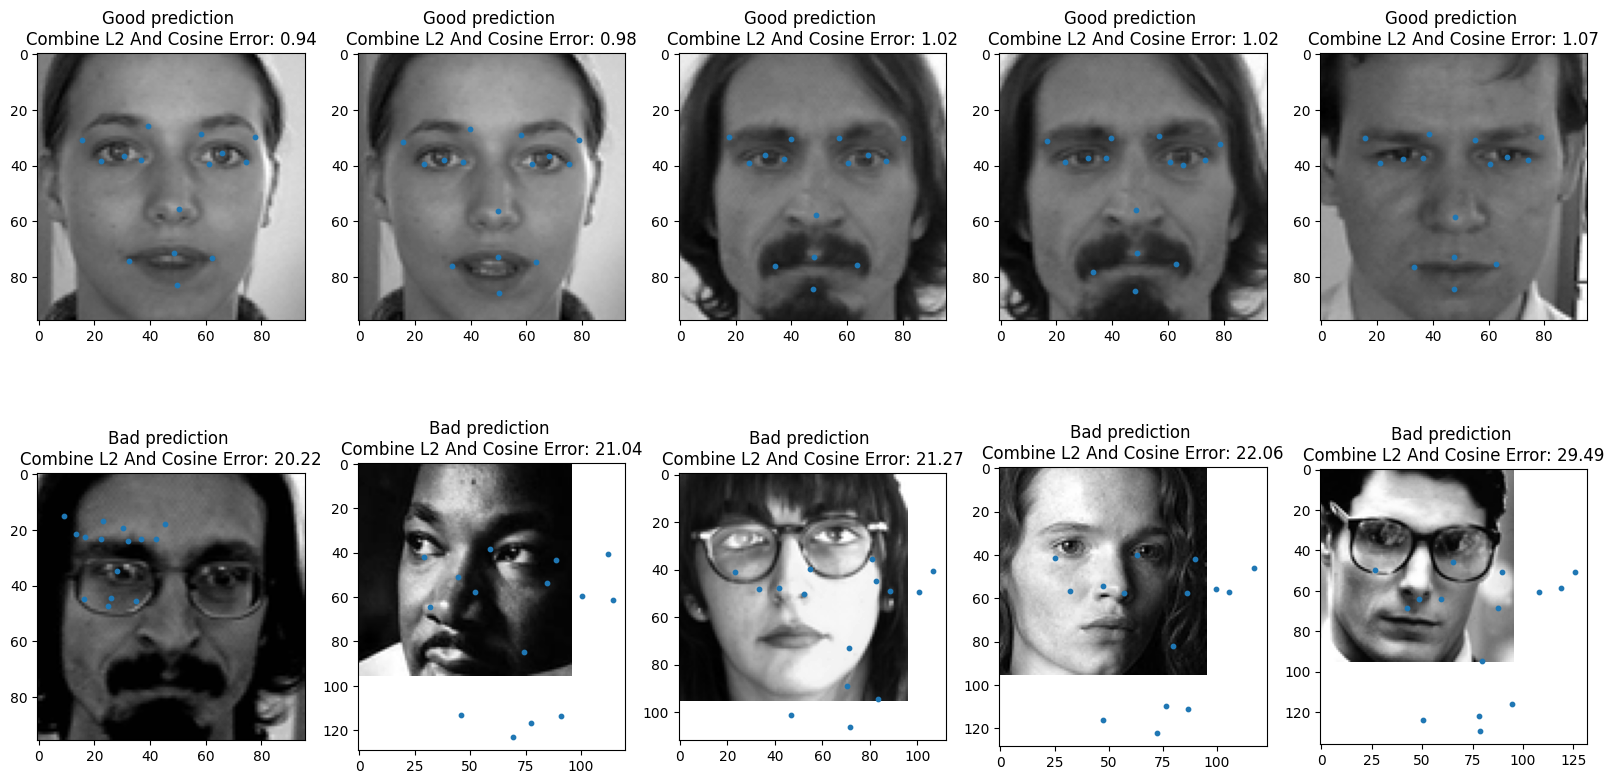

In [23]:
def plot_sample(image, landmarks, ax):
    ax.imshow(image, cmap='gray')
    landmarks = np.reshape(landmarks, (-1, 2)) # reshape to (15, 2)
    ax.scatter(landmarks[:, 0], landmarks[:, 1], marker='o', s=10)

# suppose we have some predictions and ground truth data
predictions = model.predict(test_img)
ground_truth = test_lmrk  # assume this exists

errors = np.mean(np.abs(predictions - ground_truth), axis=1)
sorted_indices = np.argsort(errors)

# Indices of good predictions
good_indices = sorted_indices[:5]  

# Indices of bad predictions
bad_indices = sorted_indices[-5:]  

fig = plt.figure(figsize=(20,10))
for i in range(5):
    # Good predictions
    ax = fig.add_subplot(2, 5, i+1)
    plot_sample(test_img[good_indices[i]], predictions[good_indices[i]], ax)
    ax.set_title("Good prediction \nCombine L2 And Cosine Error: {:.2f}".format(errors[good_indices[i]]))

    # Bad predictions
    ax = fig.add_subplot(2, 5, i+6)
    plot_sample(test_img[bad_indices[i]], predictions[bad_indices[i]], ax)
    ax.set_title("Bad prediction \nCombine L2 And Cosine Error: {:.2f}".format(errors[bad_indices[i]]))

plt.show()
